In [6]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import utils.behavioral_utils as behavioral_utils
import utils.information_utils as information_utils
import utils.visualization_utils as visualization_utils
import utils.glm_utils as glm_utils
from matplotlib import pyplot as plt
import utils.spike_utils as spike_utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
OUTPUT_DIR = "/data/patrick_res/glm"

In [8]:
SESSIONS_PATH = "/data/patrick_res/sessions/valid_sessions_rpe.pickle"
sessions = pd.read_pickle(SESSIONS_PATH)

In [9]:
feedback_idxs = np.arange(13, 28, 1)
choice_idxs = np.arange(0, 13, 1)

In [10]:
alpha = 0.01
def get_res_per_session(row):
    session = row.session_name
    separate_res = pd.read_pickle(os.path.join(OUTPUT_DIR, f"{session}_glm_feature_rpe_separate.pickle"))
    separate_res["TimeIdxs"] = (separate_res["TimeBins"] * 10).astype(int)
    separate_res = separate_res.rename(columns={"score": "separate_score"})

    interaction_res = pd.read_pickle(os.path.join(OUTPUT_DIR, f"{session}_glm_feature_rpe_interaction.pickle"))
    interaction_res["TimeIdxs"] = (interaction_res["TimeBins"] * 10).astype(int)
    interaction_res = interaction_res.rename(columns={"score": "interaction_score"})

    shuffled_res = pd.read_pickle(os.path.join(OUTPUT_DIR, f"{session}_glm_feature_rpe_shuffles.pickle"))        
    shuffled_res["TimeIdxs"] = (shuffled_res["TimeBins"] * 10).astype(int)

    sig_stats = glm_utils.calculate_sig_stats(shuffled_res, alpha, 1)
    sig_stats["TimeIdxs"] = (sig_stats["TimeBins"] * 10).astype(int)

    merged = pd.merge(separate_res, interaction_res, on=["UnitID", "TimeIdxs"])
    merged = pd.merge(merged, sig_stats, on=["UnitID", "TimeIdxs"])

    pos = spike_utils.get_unit_positions_per_sess(session)
    pos = pos.fillna("unknown")
    pos = spike_utils.get_manual_structure(pos)

    with_pos = pd.merge(merged, pos, on=["UnitID"])
    with_pos["PseudoUnitID"] = int(session) * 100 + with_pos["UnitID"]
    return with_pos[["PseudoUnitID", "TimeBins", "TimeIdxs", "separate_score", "interaction_score", "sig_bound", "manual_structure"]]

In [11]:
unit_res = pd.concat(sessions.apply(get_res_per_session, axis=1).values).reset_index(drop=True)


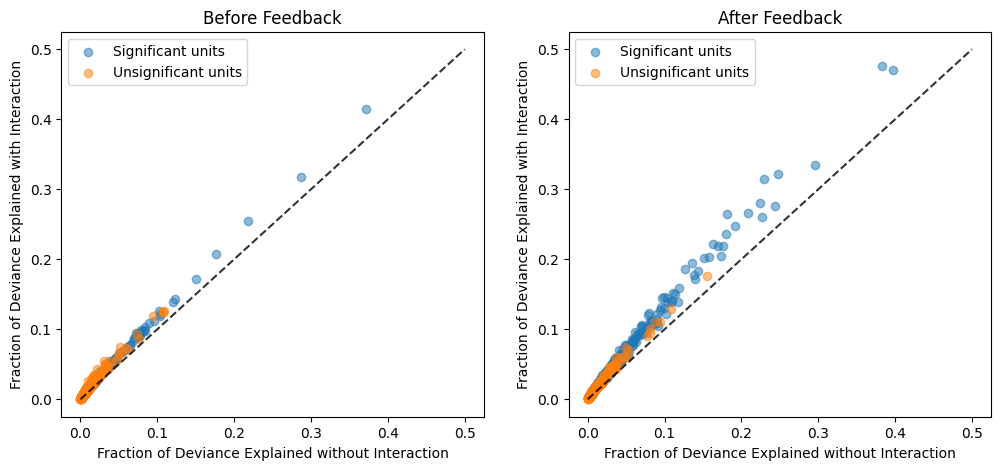

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
titles = ["Before Feedback", "After Feedback"]
for i, time_idxs in enumerate([choice_idxs, feedback_idxs]):
    ax = axs[i]
    time_unit_res = unit_res[unit_res.TimeIdxs.isin(time_idxs)]
    def get_max(group):
        return group.loc[group.interaction_score.idxmax()]
    maxes = time_unit_res.groupby("PseudoUnitID").apply(get_max)

    sig_units = maxes[maxes.interaction_score > maxes.sig_bound]
    unsig_units = maxes[maxes.interaction_score <= maxes.sig_bound]
    # non_sig_units = maxes[maxes.interaction_score <=maxes.sig_bound]
    # ax.scatter(non_sig_units.separate_score, non_sig_units.interaction_score, alpha=0.8)
    ax.scatter(sig_units.separate_score, sig_units.interaction_score, alpha=0.5, label="Significant units")
    ax.scatter(unsig_units.separate_score, unsig_units.interaction_score, alpha=0.5, label="Unsignificant units")

    # for area in ["Hippocampus/MTL", "Basal Ganglia", "Anterior Cingulate Gyrus"]:
    #     area_units = sig_units[sig_units.manual_structure == area]
    #     ax.scatter(area_units.separate_score, area_units.interaction_score, alpha=0.8, label=area)
    ax.legend()
    ax.set_xlabel("Fraction of Deviance Explained without Interaction")
    ax.set_ylabel("Fraction of Deviance Explained with Interaction")

    ax.set_title(titles[i])
    ax.plot(np.arange(0, 0.6, 0.1), np.arange(0, 0.6, 0.1), linestyle="--", color="black", alpha=0.8)

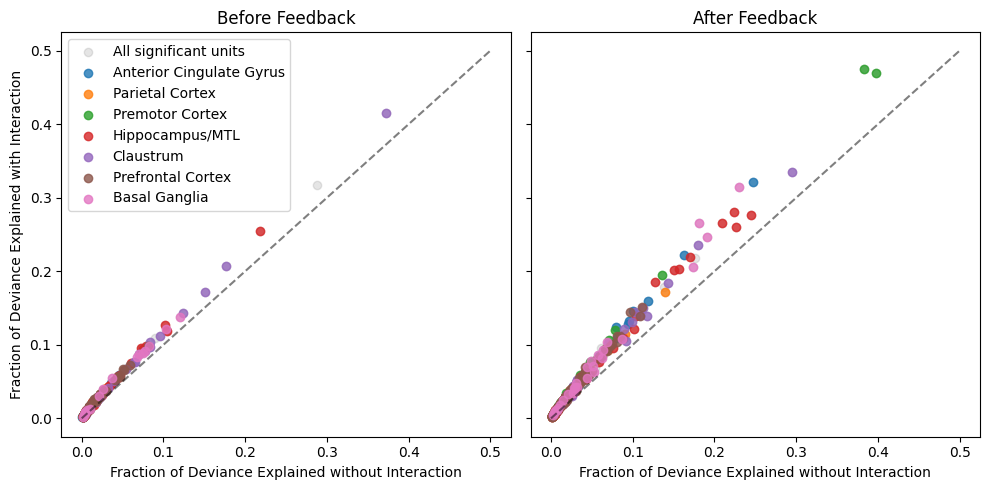

In [35]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
titles = ["Before Feedback", "After Feedback"]
for i, time_idxs in enumerate([choice_idxs, feedback_idxs]):
    ax = axs[i]
    time_unit_res = unit_res[unit_res.TimeIdxs.isin(time_idxs)]
    def get_max(group):
        return group.loc[group.interaction_score.idxmax()]
    maxes = time_unit_res.groupby("PseudoUnitID").apply(get_max)

    sig_units = maxes[maxes.interaction_score > maxes.sig_bound]
    ax.scatter(sig_units.separate_score, sig_units.interaction_score, alpha=0.2, color="gray", label="All significant units")
    for area in ["Anterior Cingulate Gyrus", "Parietal Cortex", "Premotor Cortex", "Hippocampus/MTL", "Claustrum", "Prefrontal Cortex", "Basal Ganglia"]:
        area_units = sig_units[sig_units.manual_structure == area]
        ax.scatter(area_units.separate_score, area_units.interaction_score, alpha=0.8, label=area)
    if i == 0:
        ax.legend()
        ax.set_ylabel("Fraction of Deviance Explained with Interaction")
    ax.set_xlabel("Fraction of Deviance Explained without Interaction")
    # ax.set_xscale("log")
    # ax.set_yscale("log")
    # ax.set_xlim(0.001, 0.5)
    # ax.set_ylim(0.001, 0.5)

    ax.set_title(titles[i])
    ax.plot(np.arange(0, 0.6, 0.1), np.arange(0, 0.6, 0.1), linestyle="--", color="black", alpha=0.5)
fig.tight_layout()

In [26]:
time_unit_res = unit_res[unit_res.TimeIdxs.isin(feedback_idxs)]

# interesting_units = time_unit_res[time_unit_res.interaction_score > 0.1]
interesting_units = time_unit_res


In [27]:
time_unit_res.TimeBins.unique()

array([1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5,
       2.6, 2.7])

In [28]:
interesting_units["ratio"] = interesting_units.interaction_score / interesting_units.separate_score

/tmp/ipykernel_378979/820409179.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  interesting_units["ratio"] = interesting_units.interaction_score / interesting_units.separate_score


In [30]:
interesting_units.sort_values(by="ratio", ascending=False)[:50]

,PseudoUnitID,TimeBins,TimeIdxs,separate_score,interaction_score,sig_bound,manual_structure,ratio
19476,2018071241,1.6,16,0.001389,0.009197,0.014092,Prefrontal Cortex,6.621905
3381,2018091222,2.1,21,0.000306,0.001838,0.002928,Amygdala,6.000038
6018,2018080118,2.6,26,0.000314,0.001389,0.001887,Prefrontal Cortex,4.419927
19646,2018071247,1.8,18,0.007199,0.031804,0.049750,Amygdala,4.417660
13546,2018100406,2.2,22,0.002689,0.011731,0.017206,Parietal Cortex,4.362501
7918,20180725000126,2.2,22,0.002104,0.009177,0.015245,Prefrontal Cortex,4.360792
18730,2018071214,2.6,26,0.000574,0.002493,0.004051,Prefrontal Cortex,4.344956
3235,2018091217,1.5,15,0.001756,0.007434,0.009858,unknown,4.233542
51,2018070901,2.3,23,0.000319,0.001346,0.002211,Claustrum,4.220567
9990,2018080231,2.2,22,0.000338,0.001420,0.001503,Parietal Cortex,4.199168
